In [3]:

import gymnasium as gym
import numpy as np
import pygame
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [34]:
class MazeGameEnv(gym.Env):
    def __init__(self, maze, alpha=0.1, gamma=0.99, epsilon=0.1):
        super(MazeGameEnv, self).__init__()
        self.maze = np.array(maze)
        self.start_pos = tuple(np.argwhere(self.maze == 'S')[0])
        self.goal_pos = tuple(np.argwhere(self.maze == 'G')[0])
        self.current_pos = self.start_pos
        self.num_rows, self.num_cols = self.maze.shape

        self.alpha = alpha  # Taxa de aprendizado
        self.gamma = gamma  # Fator de desconto
        self.epsilon = epsilon  # Probabilidade de exploração

        # Define ação como Discrete com 4 ações (cima, baixo, esquerda, direita)
        self.action_space = gym.spaces.Discrete(4)

        # Defina o espaço de observação como uma tupla com o número de linhas e colunas
        self.observation_space = gym.spaces.Tuple((gym.spaces.Discrete(self.num_rows), gym.spaces.Discrete(self.num_cols)))

        # Inicialize o ambiente Pygame
        pygame.init()

        # Defina cores
        self.WHITE = (255, 255, 255)
        self.GREEN = (0, 255, 0)
        self.RED = (255, 0, 0)
        self.BLACK = (0, 0, 0)
        self.PURPLE = (255, 0, 255)

    def reset(self):
        self.current_pos = self.start_pos
        return self.current_pos

    def step(self, action, reward = 1):
        if action == 0:  # Cima
            self.move('up')
        elif action == 1:  # Baixo
            self.move('down')
        elif action == 2:  # Esquerda
            self.move('left')
        elif action == 3:  # Direita
            self.move('right')

        obs = self.current_pos
        #
        if(reward == 1):
            #reward = 1 if self.current_pos == self.goal_pos else 0
            distance_to_goal = abs(self.current_pos[0] - self.goal_pos[0]) + abs(self.current_pos[1] - self.goal_pos[1])
            reward = 1 / (distance_to_goal + 1)  
            done = self.current_pos == self.goal_pos
        else:
            reward = ""
            done = ""
            
        info = {}

        return obs, reward, done, info
    
    def move(self, action):
        new_pos = list(self.current_pos)

        if action == 'up':
            new_pos[0] -= 1
        elif action == 'down':
            new_pos[0] += 1
        elif action == 'left':
            new_pos[1] -= 1
        elif action == 'right':
            new_pos[1] += 1

        new_pos = tuple(new_pos)

        if self.is_valid_position(new_pos[0], new_pos[1]):
            self.current_pos = new_pos

    def is_valid_position(self, row, col):
        return 0 <= row < self.num_rows and 0 <= col < self.num_cols and self.maze[row, col] != '#'


    def render(self, mode='human'):
        if mode == 'human':
            self.draw_maze()
            pygame.display.update()
            
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
        
        if mode == 'blank':
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()

    def draw_maze(self):
        self.cell_size = 50
        self.screen_width = self.num_cols * self.cell_size
        self.screen_height = self.num_rows * self.cell_size
        self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
        self.screen.fill(self.WHITE)
        
        for row in range(self.num_rows):
            for col in range(self.num_cols):
                cell_left = col * self.cell_size
                cell_top = row * self.cell_size

                if self.maze[row, col] == '#':
                    pygame.draw.rect(self.screen, self.BLACK, (cell_left, cell_top, self.cell_size, self.cell_size))
                elif self.maze[row, col] == 'S':
                    pygame.draw.rect(self.screen, self.GREEN, (cell_left, cell_top, self.cell_size, self.cell_size))
                elif self.maze[row, col] == 'G':
                    pygame.draw.rect(self.screen, self.RED, (cell_left, cell_top, self.cell_size, self.cell_size))

        current_row, current_col = self.current_pos
        pygame.draw.rect(self.screen, self.PURPLE, (current_col * self.cell_size, current_row * self.cell_size, self.cell_size, self.cell_size))

    def close(self):
        pygame.quit()


In [30]:
maze = [
    ['S', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '#', '.', '#', '.', '.', '.'],
    ['.', '.', '.', '.', '#', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '#', '.', '.', '.', '#', '.'],
    ['.', '.', '.', '.', '#', '.', '.', '.', '.', '.'],
    ['.', '#', '#', '#', '#', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '#', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '#', '.', '.', '.', '.', '.', '.', '.', 'G'],
]

In [55]:
maze = [
    ['S','.','.','.','.','.'],
    ['.','.','.','#','.','.'],
    ['.','.','.','#','.','.'],
    ['.','.','.','#','.','.'],
    ['.','#','#','#','.','.'],
    ['.','.','.','.','.','G']
]

In [31]:
env = MazeGameEnv(maze)

done = False
state = env.reset()
env.render()

while not done:
    action = env.action_space.sample()  # Exemplo: selecione uma ação aleatória
    state, reward, done, _ = env.step(action)
    #print(state, reward, done)
    env.render()
    pygame.time.delay(10)

print("Done!")
env.close()

Done!


In [7]:
class QLearn:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.99, exploration_prob=0.1):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_prob = exploration_prob

        self.q_table = np.zeros((env.num_rows, env.num_cols, env.action_space.n))

    def train(self, num_episodes):
        for episode in range(num_episodes):
            state = self.env.reset()
            done = False

            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)

                # Atualize a tabela Q usando o algoritmo Q-learning
                q_value = self.q_table[state][action]
                max_next_q = np.max(self.q_table[next_state])
                new_q_value = (1 - self.learning_rate) * q_value + self.learning_rate * (reward + self.discount_factor * max_next_q)
                self.q_table[state][action] = new_q_value

                state = next_state

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_prob:
            return self.env.action_space.sample()  # Ação aleatória para exploração
        else:
            return np.argmax(self.q_table[state])


In [20]:
env = MazeGameEnv(maze)
q_agent = QLearn(env)

# Treine o agente usando Q-learning
q_agent.train(num_episodes=1000)

# Use a política aprendida para navegar no ambiente
state = env.reset()
done = False

while not done:
    action = q_agent.choose_action(state)
    state, _, done, _ = env.step(action)
    env.render()

env.close()

KeyboardInterrupt: 

In [12]:
import numpy as np
import heapq

class PathFinder:
    def __init__(self, env, q_table):
        self.env = env
        self.q_table = q_table

    def find_optimal_path(self):
        start = self.env.start_pos
        goal = self.env.goal_pos

        g_score = {pos: float('inf') for pos in self.q_table.shape[:2]}
        g_score[start] = 0

        path = self.a_star(start, goal, g_score)
        return path

    def a_star(self, start, goal, g_score):
        open_list = []
        heapq.heappush(open_list, (0, start))
        came_from = {}
        g_score = {pos: float('inf') for pos in self.q_table.shape[:2]}
        g_score[start] = 0
        f_score = {pos: float('inf') for pos in self.q_table.shape[:2]}
        f_score[start] = self.heuristic(start, goal)

        while open_list:
            _, current = heapq.heappop(open_list)
            if current == goal:
                return self.reconstruct_path(came_from, current)
            
            for action in range(self.env.action_space.n):
                new_pos = self.take_action(current, action)
                if not self.env.is_valid_position(*new_pos):
                    continue

                tentative_g_score = g_score[current] + 1
                if tentative_g_score < g_score[new_pos]:
                    came_from[new_pos] = current
                    g_score[new_pos] = tentative_g_score
                    f_score[new_pos] = g_score[new_pos] + self.heuristic(new_pos, goal)
                    heapq.heappush(open_list, (f_score[new_pos], new_pos))

    def heuristic(self, pos, goal):
        return abs(pos[0] - goal[0]) + abs(pos[1] - goal[1])

    def take_action(self, pos, action):
        if action == 0:  # Cima
            return (pos[0] - 1, pos[1])
        elif action == 1:  # Baixo
            return (pos[0] + 1, pos[1])
        elif action == 2:  # Esquerda
            return (pos[0], pos[1] - 1)
        elif action == 3:  # Direita
            return (pos[0], pos[1] + 1)

    def reconstruct_path(self, came_from, current):
        path = [current]
        while current in came_from:
            current = came_from[current]
            path.append(current)
        return list(reversed(path))

In [15]:
env = MazeGameEnv(maze)
q_agent = QLearn(env)

# Treine o agente usando Q-learning
q_agent.train(num_episodes=10)

# Use a política aprendida para navegar no ambiente
state = env.reset()
done = False

while not done:
    action = q_agent.choose_action(state)
    state, _, done, _ = env.step(action)
    env.render()

# Encontre e exiba o caminho ótimo
path_finder = PathFinder(env, q_agent.q_table)
optimal_path = path_finder.find_optimal_path()
print("Caminho Ótimo:", optimal_path)

env.close()

KeyboardInterrupt: 

: 

In [56]:
class MonteCarlo:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.99, exploration_prob=0.1):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_prob = exploration_prob
        
        self.Q_table = {}
        for row in range(env.num_rows):
            for col in range(env.num_cols):
                state = (row, col)    #destino
                self.Q_table[state] = np.zeros(env.action_space.n)
    
        self.acoe = [0,1,2,3]
        self.reward = -1
        self.VI = np.zeros((env.num_cols, env.num_rows))
        
        self.dest = []
        self.dest.append(list(state))
        self.gamm_arr = {(x, y):list() for x in range(env.num_cols) for y in range(env.num_rows)}
        self.vabs = {(x, y):list() for x in range(env.num_cols) for y in range(env.num_rows)}
        self.sta = [[x, y] for x in range(env.num_cols) for y in range(env.num_rows)] 
        
    def epocas(self):
        begin_state = env.start_pos  
        epocas = []
        while True:
            # Se estado igual destino encerra a epoca
            if list(begin_state) in self.dest:
                return epocas
            # Seleciona de forma randomica uma ação (cima , esquerda, ...   )
            action = random.choice(self.acoe)
            
            # Retorna os novos estados que podem ser utilizados
            new_state, _, _, _ = env.step(action)  # valida se tem parede ou borda
            # Cria lista das epocas
            epocas.append([list(begin_state), action, self.reward, list(new_state)])

            begin_state = new_state
            #print (begin_state)    
        
    def MC(self, mc_interactions):
        for z in tqdm(range(mc_interactions)):
            epoc = self.epocas()
            ga = 0
            vi_ant = None
            count = 0
            for i, passo in enumerate(epoc[::-1]):
                ga = env.gamma*ga + passo[2]
                # Começa pelas epocas proximas ao destino
                if passo[0] not in [x[0] for x in epoc[::-1][len(epoc)-i:]]:
                    # Pega posicao que vai ser calculada
                    idx = (passo[0][0], passo[0][1])
                    # Monta uma lista de gamma para posição  
                    self.gamm_arr[idx].append(ga)
                    # Calcula a media de todos os gammas da posicao
                    newValue = np.average(self.gamm_arr[idx])
                    # Monta uma lista na posição com o calculo do valor absoluto da diferença entre as posições - antiga e nova
                    self.vabs[idx[0], idx[1]].append(np.abs(self.VI[idx[0], idx[1]]-newValue))
                    # lista com os valores de interacao 
                    self.VI[idx[0], idx[1]] = newValue
                    
            if np.array_equiv(self.vabs, vi_ant):
                #cont += 1
                #if cont == 5:    
                print (f'convergiu !!! Epoca{i} {self.VI}')
            #else:
            #    cont = 0
            
            if z in [100,200,300, 400, mc_interactions-1]:
                print("Iteration {}".format(z+1))
                print(self.VI)
                print("")
                        
            vabs_ant = self.vabs
        
        plt.figure(figsize=(20,10))
        all_series = [list(x)[:50] for x in self.vabs.values()]
        for series in all_series:
            plt.plot(series)
            
    def find_optimal_path(self):
        state = env.start_pos
        optimal_path = [state]

        while state != env.goal_pos:
            action = np.argmax(self.Q_table[state])
            env.move(action)
            state = env.current_pos
            optimal_path.append(state)

        print(self.VI)
        return optimal_path
                
        

100%|██████████| 50/50 [00:00<00:00, 349.65it/s]

Iteration 50
[[-1.         -2.49995688 -2.49970104 -2.49588225 -2.49391835 -2.49999659]
 [-2.5        -2.5        -2.5         0.         -2.49068721 -2.49567737]
 [-2.49999671 -2.5        -2.5         0.         -2.44252727 -2.39955673]
 [-2.49997762 -2.5        -2.5         0.         -2.40019944 -2.15636342]
 [-2.49766834  0.          0.          0.         -2.02424074 -1.53886047]
 [-2.49281618 -2.4790327  -2.43394657 -2.18935944 -1.329       0.        ]]

[['S', '.', '.', '.', '.', '.'], ['.', '.', '.', '#', '.', '.'], ['.', '.', '.', '#', '.', '.'], ['.', '.', '.', '#', '.', '.'], ['.', '#', '#', '#', '.', '.'], ['.', '.', '.', '.', '.', 'G']]
[[-1.         -2.49995688 -2.49970104 -2.49588225 -2.49391835 -2.49999659]
 [-2.5        -2.5        -2.5         0.         -2.49068721 -2.49567737]
 [-2.49999671 -2.5        -2.5         0.         -2.44252727 -2.39955673]
 [-2.49997762 -2.5        -2.5         0.         -2.40019944 -2.15636342]
 [-2.49766834  0.          0.          0. 

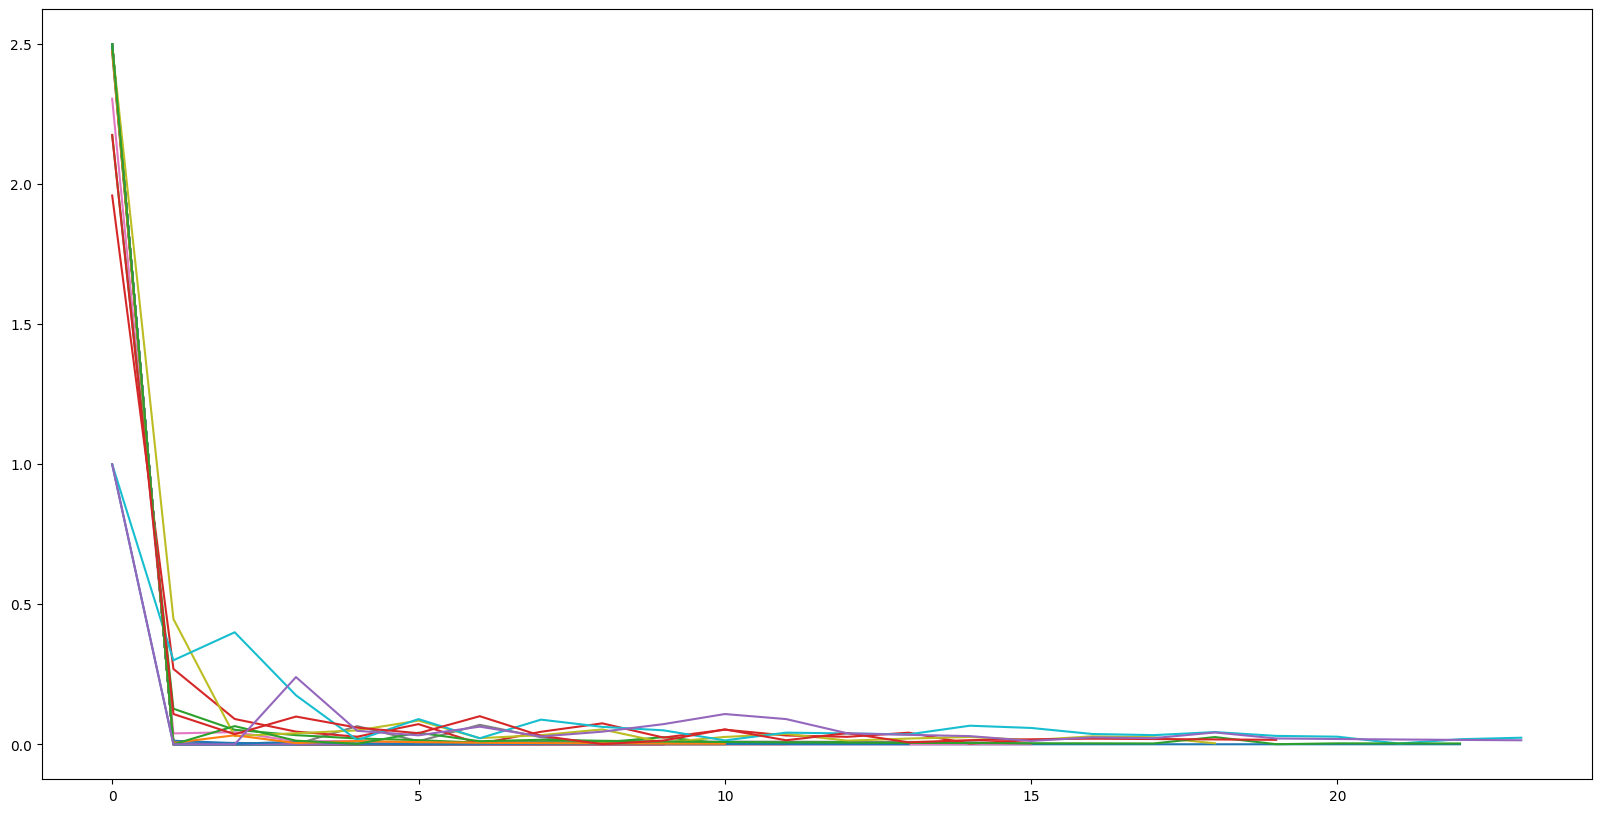

In [58]:
env = MazeGameEnv(maze, alpha=0.1, gamma=0.6, epsilon=0.1)
MC = MonteCarlo(env)
MC.MC(500)

# # Encontre o caminho ótimo do estado inicial ao estado de destino
optimal_path = MC.find_optimal_path()
print("Optimal Path:", optimal_path)